In [3]:
from gpad_data_generation import *
import numpy as np

odf, pedf, ppedf, coefs = music_processor('100605.mp3')

In [7]:
print(np.size(pedf[0]))
print(np.size(pedf[1])) 
print(np.size(pedf[2]))
print(np.size(pedf[3]))
print(np.size(pedf[4]))
print(np.size(pedf[5]))

a = 0
for x in range(6):
    a = a + np.size(pedf[x])
    
print(a)

38
38
75
149
298
595
1193


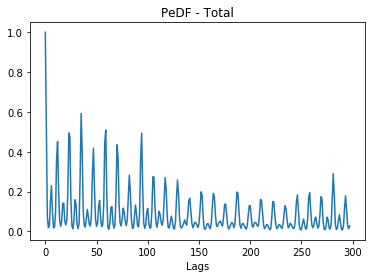

In [8]:
plot_PeDF(ppedf[5], 'partial')

In [4]:
from AE_functions import *


[0 0 0 0 8 9 7]
[0 8 9 7]
[3 0 0 0 8 9 7]


In [5]:
x = v_sc(pedf[1], 5)

(38,)
()
()


In [11]:
print(v_sd(pedf[1]))

TypeError: v_sd() missing 2 required positional arguments: 'f_s_eq' and 'NFFT'